In [1]:
import astropy.units as u

from fleck import generate_spots
from fleck import Star

import numpy as np

from altaipony.altai import aflare
import matplotlib.pyplot as plt

from altaipony.utils import generate_random_power_law_distribution

import pytest
from flares import flare_contrast

import warnings


# upgrade todo

- write an empirical `decompose_ed` (see notebook `05`)


# exploration
   
- fix the longitude of dominant spot

In [2]:
t = np.arange(0, 2 * np.pi, 2 * np.pi/600)
n_spots = 1
n_inclinations = 500
emin, emax, alpha, beta = 1, 100, -2, 100

In [3]:
flares = flare_contrast(t, n_spots, emin, emax, alpha, beta, n_inclinations)

In [4]:
u_ld = [0.5079, 0.2239]

n_phases = 1
phases = t * u.rad

# infer active region radius for each lc
spot_radius = np.array([0.01]*n_spots).reshape((n_spots,1))   # Rspot/Rstar , should be the same shape as nspotnincflare
min_latitude = 50  # deg
max_latitude = 60   # deg

# replace with generate_active_regions()
lons, lats, radii, inc_stellar = generate_spots(min_latitude, max_latitude,
                                                spot_radius, n_spots,
                                                n_inclinations=n_inclinations)



In [5]:
star = Star(spot_contrast=flares, phases=phases, u_ld=u_ld, n_phases=1)

In [6]:
lcs = star.light_curve(lons, lats, radii, inc_stellar)

In [7]:
# should be (phases, n_inclinations)
lcs.shape == (len(t), n_inclinations)

True

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


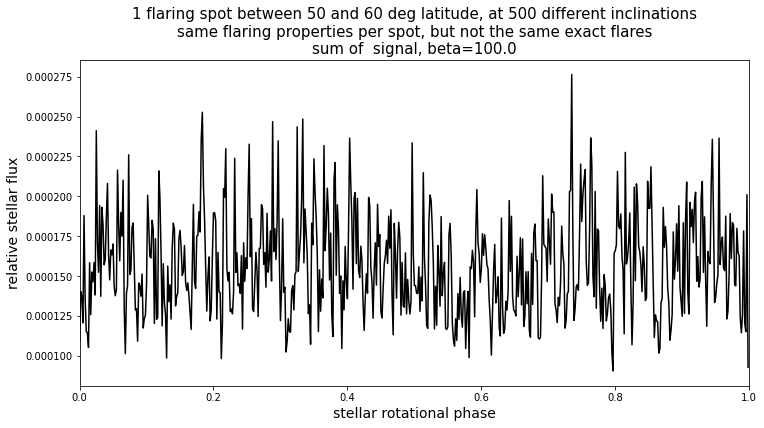

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(star.phases/2/np.pi, (lcs-1).sum(axis=1), c="k")
plt.xlim(0,1)
plt.xlabel("stellar rotational phase", fontsize=14)
plt.ylabel("relative stellar flux", fontsize=14)
plt.legend(fontsize=15, loc=1, frameon=False);
# plt.yscale("log")
plt.title(f"{n_spots} flaring spot between {min_latitude:2d} and {max_latitude:2d} deg latitude,"
          f" at {n_inclinations:2d} different inclinations\n"
          f"same flaring properties per spot, but not the same exact flares\n"
          f"sum of  signal, beta={beta:.1f}", fontsize=15);
# plt.savefig(f"plots/2021_12_20_{n_spots}_spots_distribution_{min_latitude:2d}_{max_latitude:2d}_"
#             f"sum_{n_inclinations:2d}_{beta[0]:.1f}_3.png", dpi=300);